# SBI for the parameters of a line fit
The goal is to do inference and then sample from the inferred parameters to build a posterior predictive check (of y). Then, measure the distribution of y given x, and from this return some sort of error interval.

## 1 Import all the things

In [15]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [16]:
import sbi
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi import analysis as analysis
from sbi.inference.base import infer
import torch

In [17]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

## 2 Define and test out the simulator
Like any good SBI code, you should start with the simulator. Here, each invocation of the simulator will produce a set of noisy points along a line. In other words, each invocation is defined by a noise width, m, and b.

In [64]:
true_sigma = 10
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b = thetas
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    # I'm thinking sigma could actually be a function of x
    # if we want to get fancy down the road
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x)) 
    return m * x + b + ε

def simulator_no_noise(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b = thetas
    x = np.linspace(0, 100, 101)
    return m * x + b

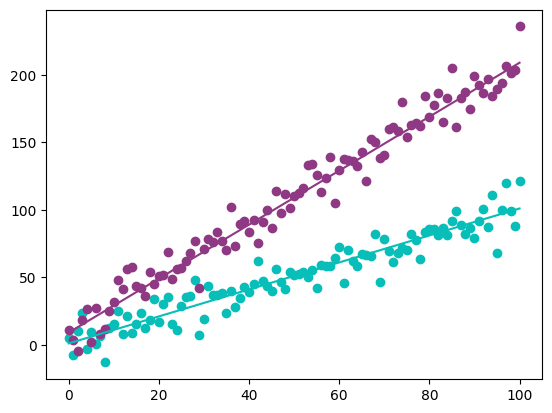

In [66]:
plt.scatter(np.linspace(0, 100, 101),
            simulator([1, 1]), color = '#07BEB8')
plt.plot(np.linspace(0, 100, 101),
            simulator_no_noise([1, 1]), color = '#07BEB8')
plt.scatter(np.linspace(0, 100, 101),
            simulator([2, 9]), color = '#8F3985')
plt.plot(np.linspace(0, 100, 101),
            simulator_no_noise([2, 9]), color = '#8F3985')
plt.show()

## 3 Generate data
This part is a placeholder for future work - 

Each data "point" is a set of points corresponding to a slope and intercept. The potential future hierarchical aspect of this is inferring things about the distribution of lines in the universe.

The effective data length is 1000 x 100 (because there are 100 x points per each data point).

In [67]:
length_df = 1000
xs = np.zeros((length_df, 2))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    #sigma = abs(rs.normal(loc=0, scale=10))
    thetas = [m, b]
    xs[r,:] = thetas
    ys.append(simulator(thetas))

In [68]:
print(np.shape(xs), np.shape(ys))

(1000, 2) (1000, 101)


## Define the prior
And then visualize them.

In [69]:
num_dim = 2

low_bounds = torch.tensor([0, -10])
high_bounds = torch.tensor([10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

<Figure size 640x480 with 0 Axes>

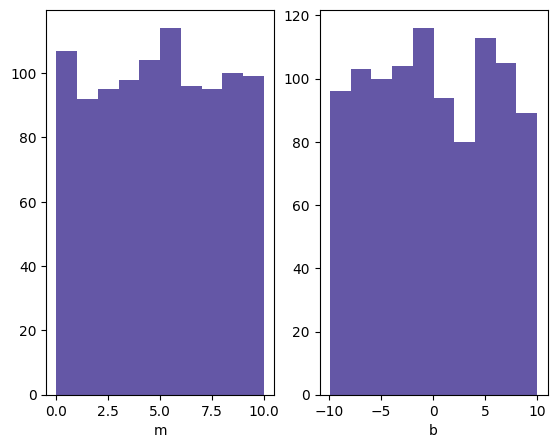

In [70]:
m_sample = []
b_sample = []

for i in range(1000):
  samp = prior.sample()
  m_sample.append(np.array(samp[0]))
  b_sample.append(np.array(samp[1]))

plt.clf()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(131)
ax0.hist(m_sample, color = '#6457A6')
ax0.set_xlabel('m')
ax1 = fig.add_subplot(132)
ax1.hist(b_sample, color = '#6457A6')
ax1.set_xlabel('b')
plt.show()

## Run the SBI
Normalizing flow; neural network magic.

In [71]:
posterior = infer(simulator, prior, "SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 68 epochs.

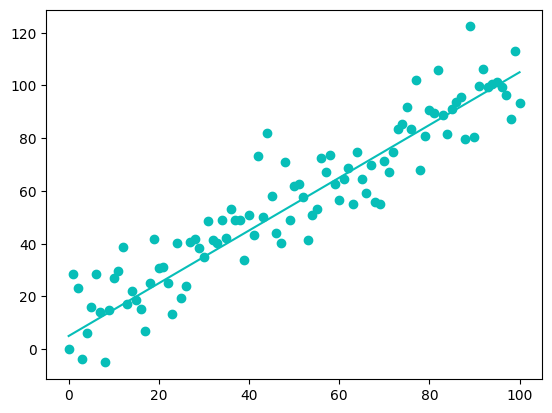

In [72]:
# generate a true dataset
theta_true = [1, 5]
y_true = simulator(theta_true)
y_true_no_noise = simulator_no_noise(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            y_true, color = '#07BEB8')
plt.plot(np.linspace(0, 100, 101),
            y_true_no_noise, color = '#07BEB8')
plt.show()



Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

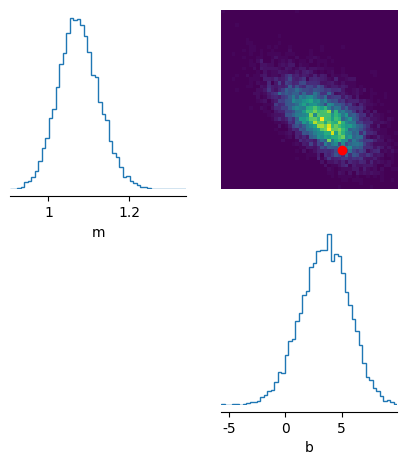

In [33]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)

# plot posterior samples
fig, axes = analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)
axes[0, 1].plot([theta_true[1]], [theta_true[0]], marker="o", color="r")

Okay but these are just the parameters. What we really want is the posterior predictive check, which is built by running draws from the posterior through the simulator again.

With or without noise in the simulator? I think without.

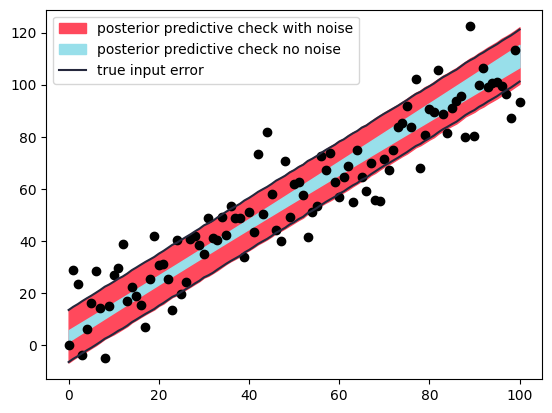

In [73]:
# also go through and plot one sigma interval
# plot the true values
plt.clf()
xs_sim = np.linspace(0, 100, 101)
ys_sim = np.zeros((np.shape(posterior_samples_1)[0], len(xs_sim)))
ys_sim_no_noise = np.zeros((np.shape(posterior_samples_1)[0], len(xs_sim)))
# for every posterior sample, run it through the no noise and the noisy simulator
for j in range(np.shape(posterior_samples_1)[0]):
    ys_sim_no_noise[j,:] = simulator_no_noise(posterior_samples_1[j,:])
    ys_sim[j,:] = simulator(posterior_samples_1[j,:])

plt.fill_between(xs_sim,
                 np.mean(ys_sim, axis = 0) - 1 * np.std(ys_sim, axis = 0),
                 np.mean(ys_sim, axis = 0) + 1 * np.std(ys_sim, axis = 0),
                 color = '#FF495C', label = 'posterior predictive check with noise')
plt.fill_between(xs_sim,
                 np.mean(ys_sim_no_noise, axis = 0) - 1 * np.std(ys_sim_no_noise, axis = 0),
                 np.mean(ys_sim_no_noise, axis = 0) + 1 * np.std(ys_sim_no_noise, axis = 0),
                 color = '#98DFEA', label = 'posterior predictive check no noise')

plt.plot(xs_sim, np.mean(ys_sim, axis = 0) + true_sigma,
         color = '#25283D', label = 'true input error')
plt.plot(xs_sim, np.mean(ys_sim, axis = 0) - true_sigma,
         color = '#25283D')
plt.scatter(xs_sim,
            y_true, 
            color = 'black')#'#EFD9CE')    
plt.legend()

plt.show()

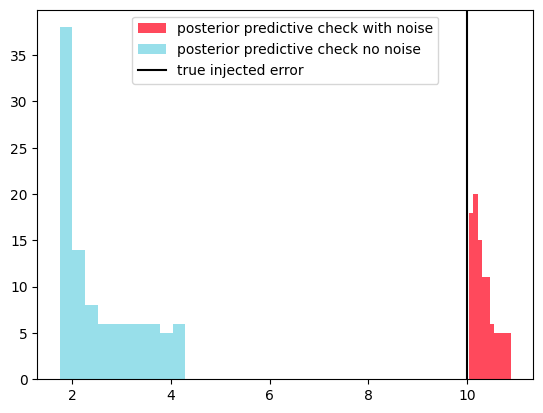

In [52]:
# Another way to look at this would be to plop it on its side and look at the sigma values at each x
plt.hist(np.std(ys_sim, axis = 0),
         label = 'posterior predictive check with noise',
         color = '#FF495C',
         bins = 10)
plt.hist(np.std(ys_sim_no_noise, axis = 0),
         label = 'posterior predictive check no noise',
         color = '#98DFEA',
         bins = 10)
plt.axvline(x = true_sigma,
            color = 'black',
            label = 'true injected error')
plt.legend()
plt.show()